In [1]:
## Notebook env: mirtud_env (R kernel)
## this notebook finds expression patterns in aggregated datasets

In [2]:
suppressMessages(library(Seurat))
suppressMessages(library(stringr))
suppressMessages(library(ggplot2))
suppressMessages(library(escape))
suppressMessages(library(dittoSeq))
suppressMessages(library(GSEABase))
suppressMessages(library(SummarizedExperiment))

In [3]:
tRF_loaded_seuratobj <- readRDS('/home/ssobti/projects/mir_tud/010523_filtered_data/tRF_normalized_integrated_seurat.rds')
meta = tRF_loaded_seuratobj@meta.data

meta$guide[str_sub(meta$guide, 1, 3) == 'TuD'] <- 'TuD_NC'
tRF_loaded_seuratobj@meta.data <- meta

Warning message:
“Removed 36 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


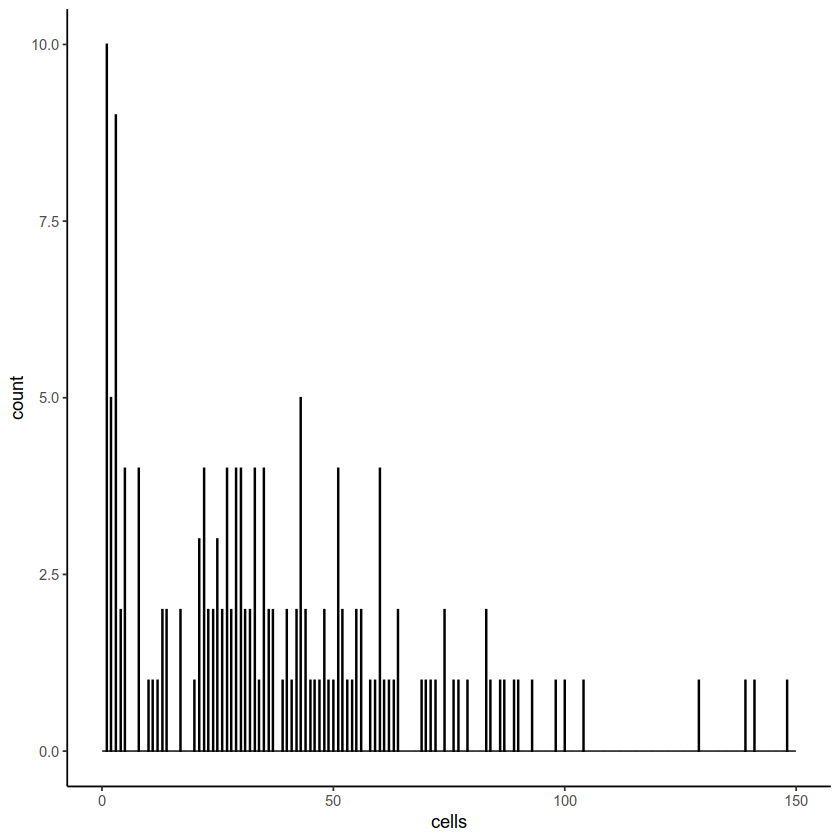

In [4]:
count_df = data.frame(guide = names(table(meta$guide)), cells = as.numeric(table(meta$guide)))
ggplot(count_df, aes(x = cells)) + geom_histogram(color="black", fill="white", position = "identity", bins = 1000) + 
xlim(0,150) + theme_classic()

In [5]:
suppressMessages(library(dplyr))
cbind(arrange(count_df, cells)[1:10,], arrange(count_df, -cells)[1:10,])

,guide,cells,guide,cells
,<chr>,<dbl>,<chr>,<dbl>
1,tRF_Leu_CAA.CAG_2,1,TuD_NC,7753
2,tRNA-Arg-TCG-2-1.3t,1,tRF_Ala_TGC.AGC_6,598
3,tRNA-Cys-GCA-4-1.3t,1,tRF_Asn_GTT_2,501
4,tRNA-Gln-CTG-(5)1-1.1t,1,tRF_Ala_CGC.AGC.TGC_5,477
5,tRNA-Lys-TTT-(5)3-1.1t,1,tRF_Gly_CCC_2,469
6,tRNA-Met-CAT-(2)3-1.1t,1,tRF_Lys_CTT_2,425
7,tRNA-Val-AAC-3-1.3t,1,tRF_Leu_TAA_2,390
8,tRNA-Val-CAC-2-1.3t,1,tRF_Gly_TCC_4,377
9,tRNA-Val-CAC-3-1.3t,1,tRF_Ser_CGA_2,333


In [6]:
### seems like # of cells per guide is a huge covariate in expression (based on heatmap below without regressing it out)
## so need to control for it here
cell_guide_count = 1:nrow(meta)
for (i in 1:nrow(count_df)){
    cell_guide_count[meta$guide == count_df$guide[i]] = count_df$cells[i]
}

meta$cell_guide_count = cell_guide_count
tRF_loaded_seuratobj@meta.data <- meta

In [ ]:
tRF_seuratobj = CreateSeuratObject(tRF_loaded_seuratobj@assays$RNA@counts, meta.data = tRF_loaded_seuratobj@meta.data)
tRF_seuratobj = NormalizeData(tRF_seuratobj)
saveRDS(tRF_seuratobj, '/home/ssobti/projects/mir_tud/output_data/genexp_pathway/tRF_seuratobj_from_pseudobulk_pathway_analysis_tRF_nb.rds')

In [8]:
tRF_seuratobj_rel_norlmalized = CreateSeuratObject(tRF_loaded_seuratobj@assays$RNA@counts, meta.data = tRF_loaded_seuratobj@meta.data)
tRF_seuratobj_rel_norlmalized = NormalizeData(tRF_seuratobj_rel_norlmalized, normalization.method = 'RC')

In [9]:
#tRF_seuratobj = ScaleData(tRF_seuratobj, features = rownames(tRF_seuratobj), vars.to.regress = c('sample', 'percent.mt', 'nCount_RNA', 'cell_guide_count'))

In [10]:
Pseudo_bulk_exp = AverageExpression(tRF_seuratobj, assays = "RNA", group.by = "guide", slot = "data")
Pseudo_bulk_exp = Pseudo_bulk_exp[['RNA']]

Pseudo_bulk_exp_counts = AverageExpression(tRF_seuratobj, assays = "RNA", group.by = "guide", slot = "counts")
Pseudo_bulk_exp_counts = Pseudo_bulk_exp_counts[['RNA']]

In [11]:
Pseudo_bulk_exp_RC = AverageExpression(tRF_seuratobj_rel_norlmalized, assays = "RNA", group.by = "guide", slot = "data")
Pseudo_bulk_exp_RC = Pseudo_bulk_exp_RC[['RNA']]

Warning message in PseudobulkExpression(object = object, pb.method = "average", :
“Exponentiation yielded infinite values. `data` may not be log-normed.”


In [12]:
GS.hallmark <- getGeneSets(library = "H")
GS.hallmark = geneIds(GS.hallmark)

In [13]:
genes_present_in_set = vector(length = length(GS.hallmark))
for (i in 1:length(GS.hallmark)){
    genes_present_in_set[i] = length(which(GS.hallmark[[i]] %in% rownames(Pseudo_bulk_exp)))
}

geneset_gene_counts_df = data.frame(gene_set = names(GS.hallmark), genes_present = genes_present_in_set)




In [14]:
suppressMessages(library(dplyr))
geneset_gene_counts_df %>% arrange(genes_present) %>% head()

,gene_set,genes_present
,<chr>,<int>
1,HALLMARK_PANCREAS_BETA_CELLS,28
2,HALLMARK_ANGIOGENESIS,31
3,HALLMARK_NOTCH_SIGNALING,31
4,HALLMARK_HEDGEHOG_SIGNALING,34
5,HALLMARK_APICAL_SURFACE,38
6,HALLMARK_WNT_BETA_CATENIN_SIGNALING,39


## Heatmaps of gene set expression

In [15]:
genesetexp_x_guide = matrix(0, nrow = length(GS.hallmark), ncol = ncol(Pseudo_bulk_exp), dimnames = list(names(GS.hallmark), colnames(Pseudo_bulk_exp)))

for (j in 1:ncol(Pseudo_bulk_exp)){
    for (i in 1:length(GS.hallmark)){
        genes = GS.hallmark[[i]][GS.hallmark[[i]] %in% rownames(Pseudo_bulk_exp)]
        genesetexp_x_guide[i,j] = mean(Pseudo_bulk_exp[genes,j])
    }
}

In [16]:
mean(range(genesetexp_x_guide))

[1] 4.333373

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  2

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



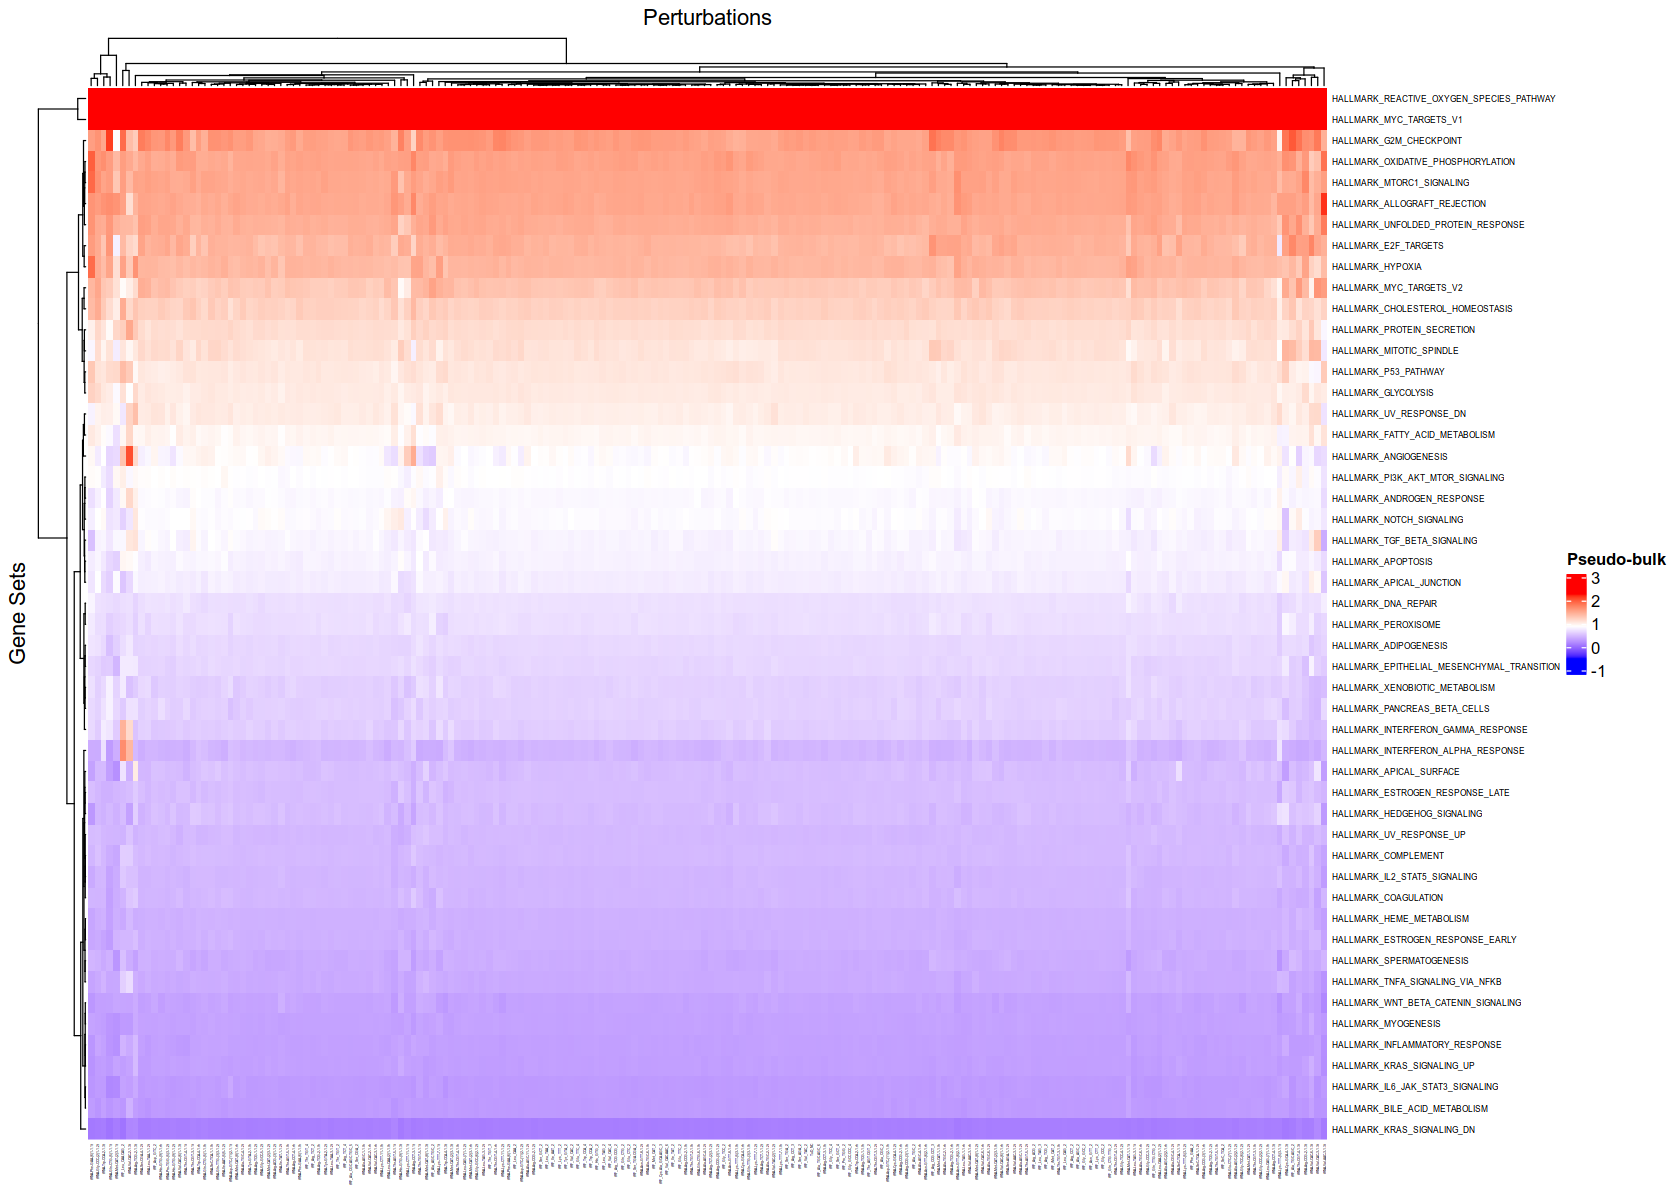

In [17]:
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(gridExtra))

avg = mean(genesetexp_x_guide)
lower_bound = mean(genesetexp_x_guide) - 2*sd(genesetexp_x_guide)
upper_bound = mean(genesetexp_x_guide) + 2*sd(genesetexp_x_guide)

coloring_map <- circlize::colorRamp2(c(lower_bound, avg, upper_bound), c("blue", "white", "red"))

perturb_htmp <- function(matrix, title) {
  draw(Heatmap(matrix, name = title, show_column_names = TRUE, show_row_names = TRUE, show_column_dend = TRUE,
               col = coloring_map, show_row_dend = TRUE, use_raster = TRUE, row_title = 'Gene Sets', 
               column_title = 'Perturbations', row_title_side = 'left', column_title_side = 'top', 
               column_names_gp = gpar(fontsize = 2), row_names_gp = gpar(fontsize = 5)))
}

options(repr.plot.width = 14, repr.plot.height = 10)

pdf('/home/ssobti/projects/mir_tud/output_data/genexp_pathway/pseudobulk_hallmark_htmap_tRF.pdf', width = 12, height = 11)
perturb_htmp(genesetexp_x_guide, 'Pseudo-bulk')
dev.off()

perturb_htmp(genesetexp_x_guide, 'Pseudo-bulk')



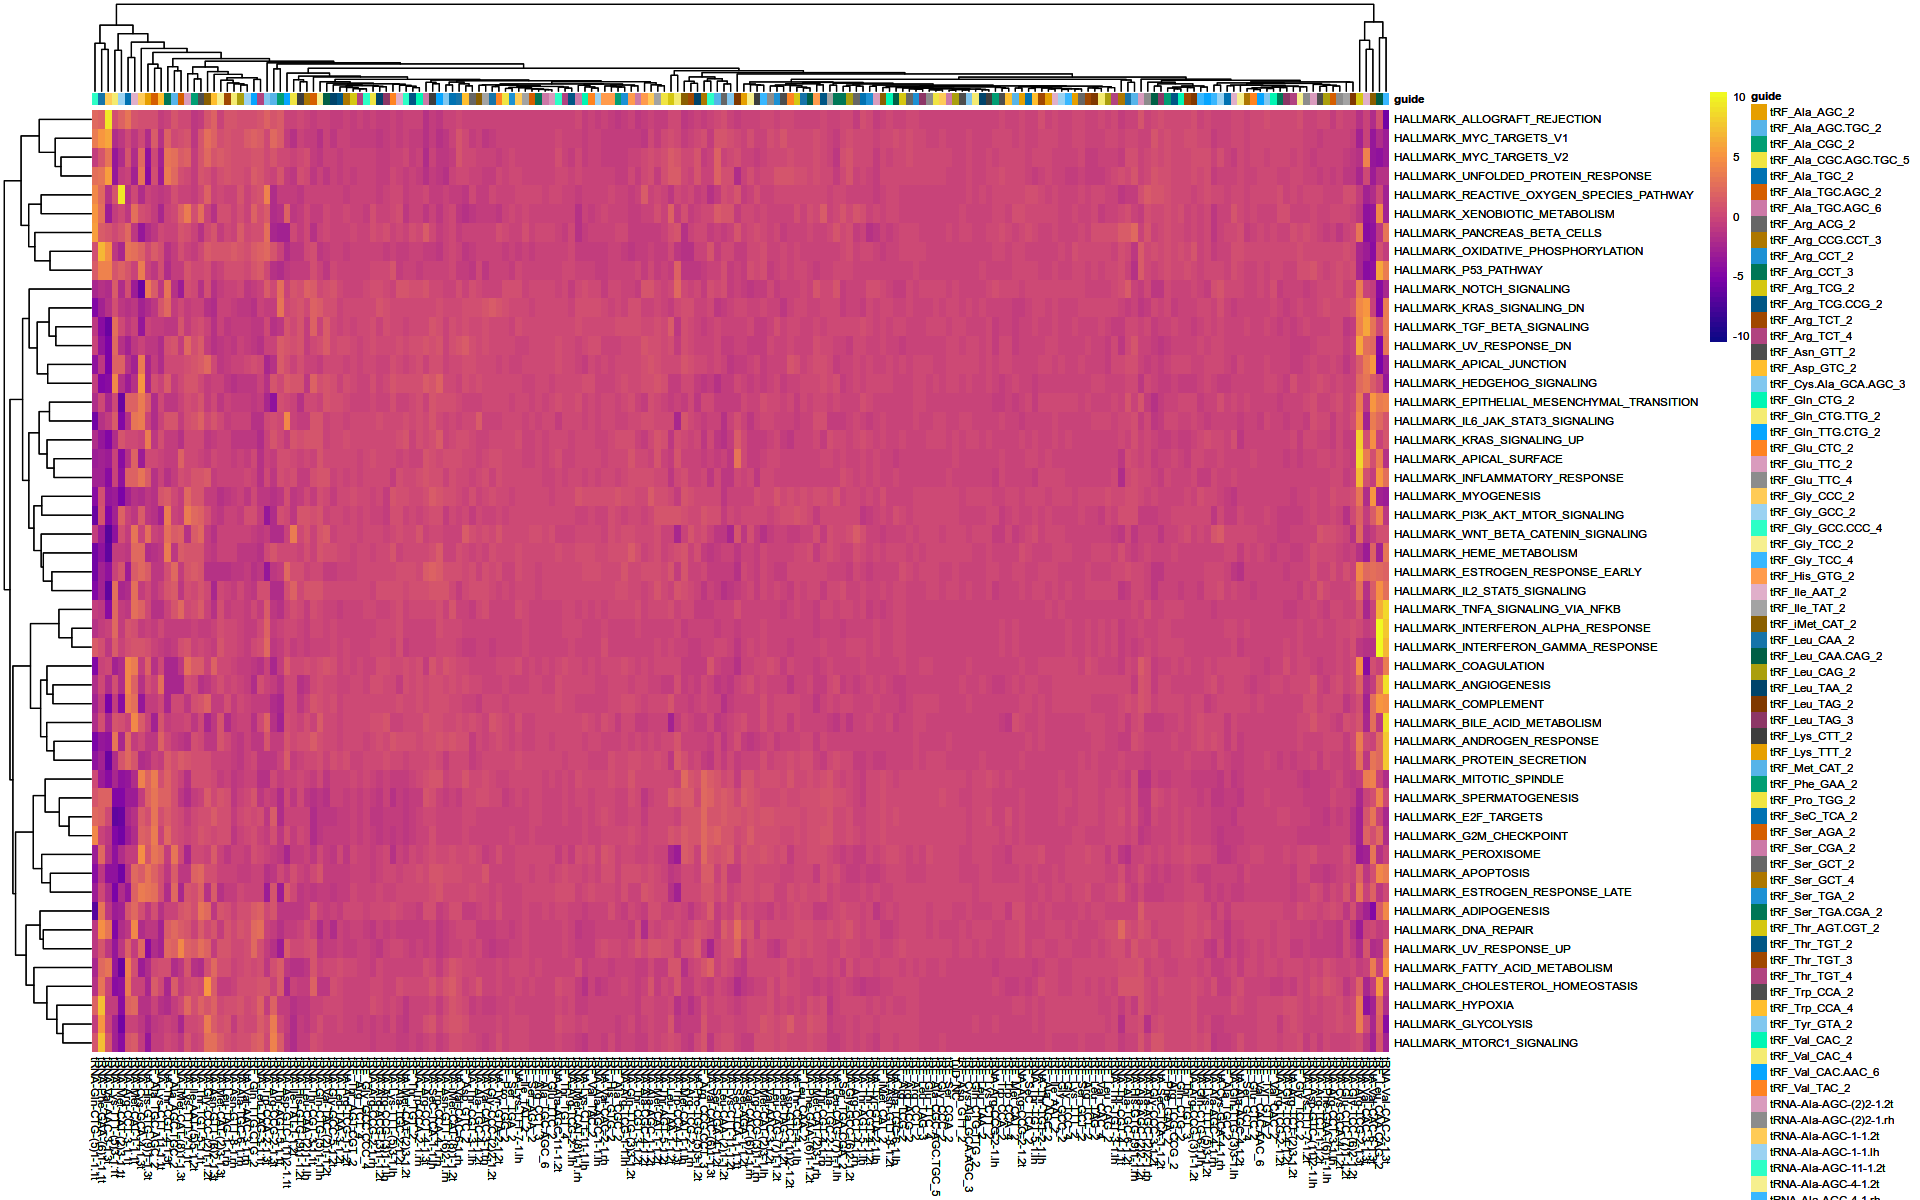

In [18]:
## better heatmap (using pheatmap and better color scheme)
coldat = cbind(guide = colnames(Pseudo_bulk_exp_counts), t(genesetexp_x_guide))
coldat = as.data.frame(coldat)
rownames(coldat) = colnames(Pseudo_bulk_exp_counts)
coldat[, 2:ncol(coldat)] <- apply(coldat[, -1], 2, as.numeric)

bulkSE <- SummarizedExperiment(assays = list(counts = Pseudo_bulk_exp_counts,
             logcounts = Pseudo_bulk_exp), colData = coldat)

colors <- colorRampPalette(c("#0D0887FF","#7E03A8FF","#CC4678FF","#F89441FF","#F0F921FF"))
options(repr.plot.width = 16, repr.plot.height = 10)


htmp = dittoHeatmap(bulkSE, genes = NULL, metas = as.character(rownames(genesetexp_x_guide)), 
             annot.by = "guide", order.by = "guide", 
             fontsize = 7, 
             cluster_cols = TRUE,
             heatmap.colors = colors(50))

htmp

In [19]:
save_pheatmap_pdf <- function(x, filename, width=30, height=12) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}

save_pheatmap_pdf(htmp, "/home/ssobti/projects/mir_tud/output_data/genexp_pathway/pseudobulk_hallmark_htmap2_tRF.pdf")

png 
  2

## Heatmaps of gene set fold change expression to TuD_NC

In [20]:
class(genesetexp_x_guide)

[1] "matrix" "array"

In [21]:
tmp_df = as.data.frame(genesetexp_x_guide)
genesetexp_x_guide_FC = tmp_df
for (i in 1:ncol(tmp_df)){
    genesetexp_x_guide_FC[,i] = tmp_df[,i]/tmp_df[,'TuD_NC']
}

genesetexp_x_guide_FC = as.matrix(genesetexp_x_guide_FC)

In [22]:
range(genesetexp_x_guide_FC)

[1] 0.4454264 3.8086815

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  2

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



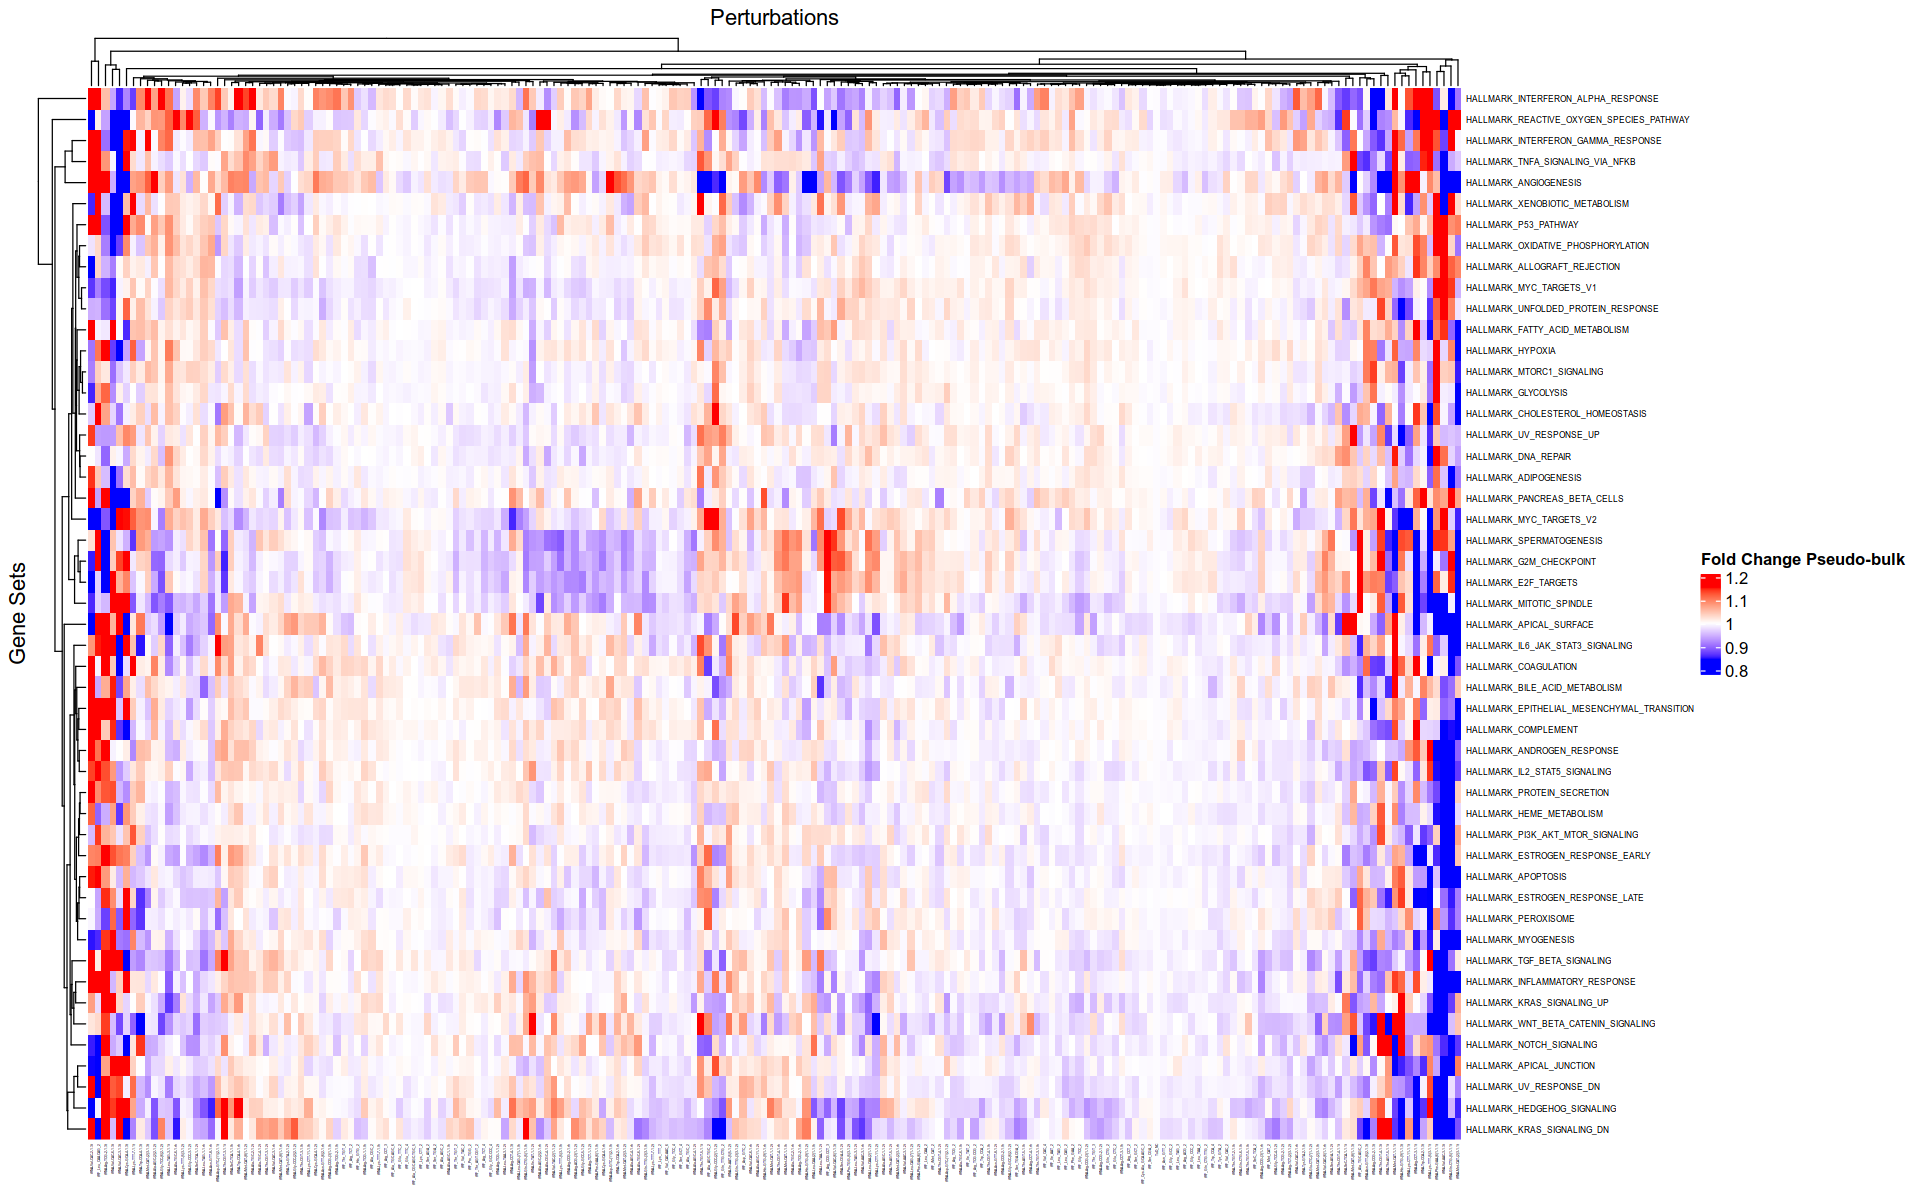

In [23]:
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(gridExtra))

avg = mean(genesetexp_x_guide_FC)
lower_bound = mean(genesetexp_x_guide_FC) - 2*sd(genesetexp_x_guide_FC)
upper_bound = mean(genesetexp_x_guide_FC) + 2*sd(genesetexp_x_guide_FC)

coloring_map <- circlize::colorRamp2(c(lower_bound, avg, upper_bound), c("blue", "white", "red"))

perturb_htmp <- function(matrix, title) {
  draw(Heatmap(matrix, name = title, show_column_names = TRUE, show_row_names = TRUE, show_column_dend = TRUE,
               col = coloring_map, show_row_dend = TRUE, use_raster = TRUE, row_title = 'Gene Sets', 
               column_title = 'Perturbations', row_title_side = 'left', column_title_side = 'top', 
               column_names_gp = gpar(fontsize = 2), row_names_gp = gpar(fontsize = 5)))
}

pdf('/home/ssobti/projects/mir_tud/output_data/genexp_pathway/pseudobulk_foldchange_hallmark_htmap_tRF.pdf', width = 12, height = 11)
perturb_htmp(genesetexp_x_guide_FC, 'Fold Change Pseudo-bulk')
dev.off()

perturb_htmp(genesetexp_x_guide_FC, 'Fold Change Pseudo-bulk')

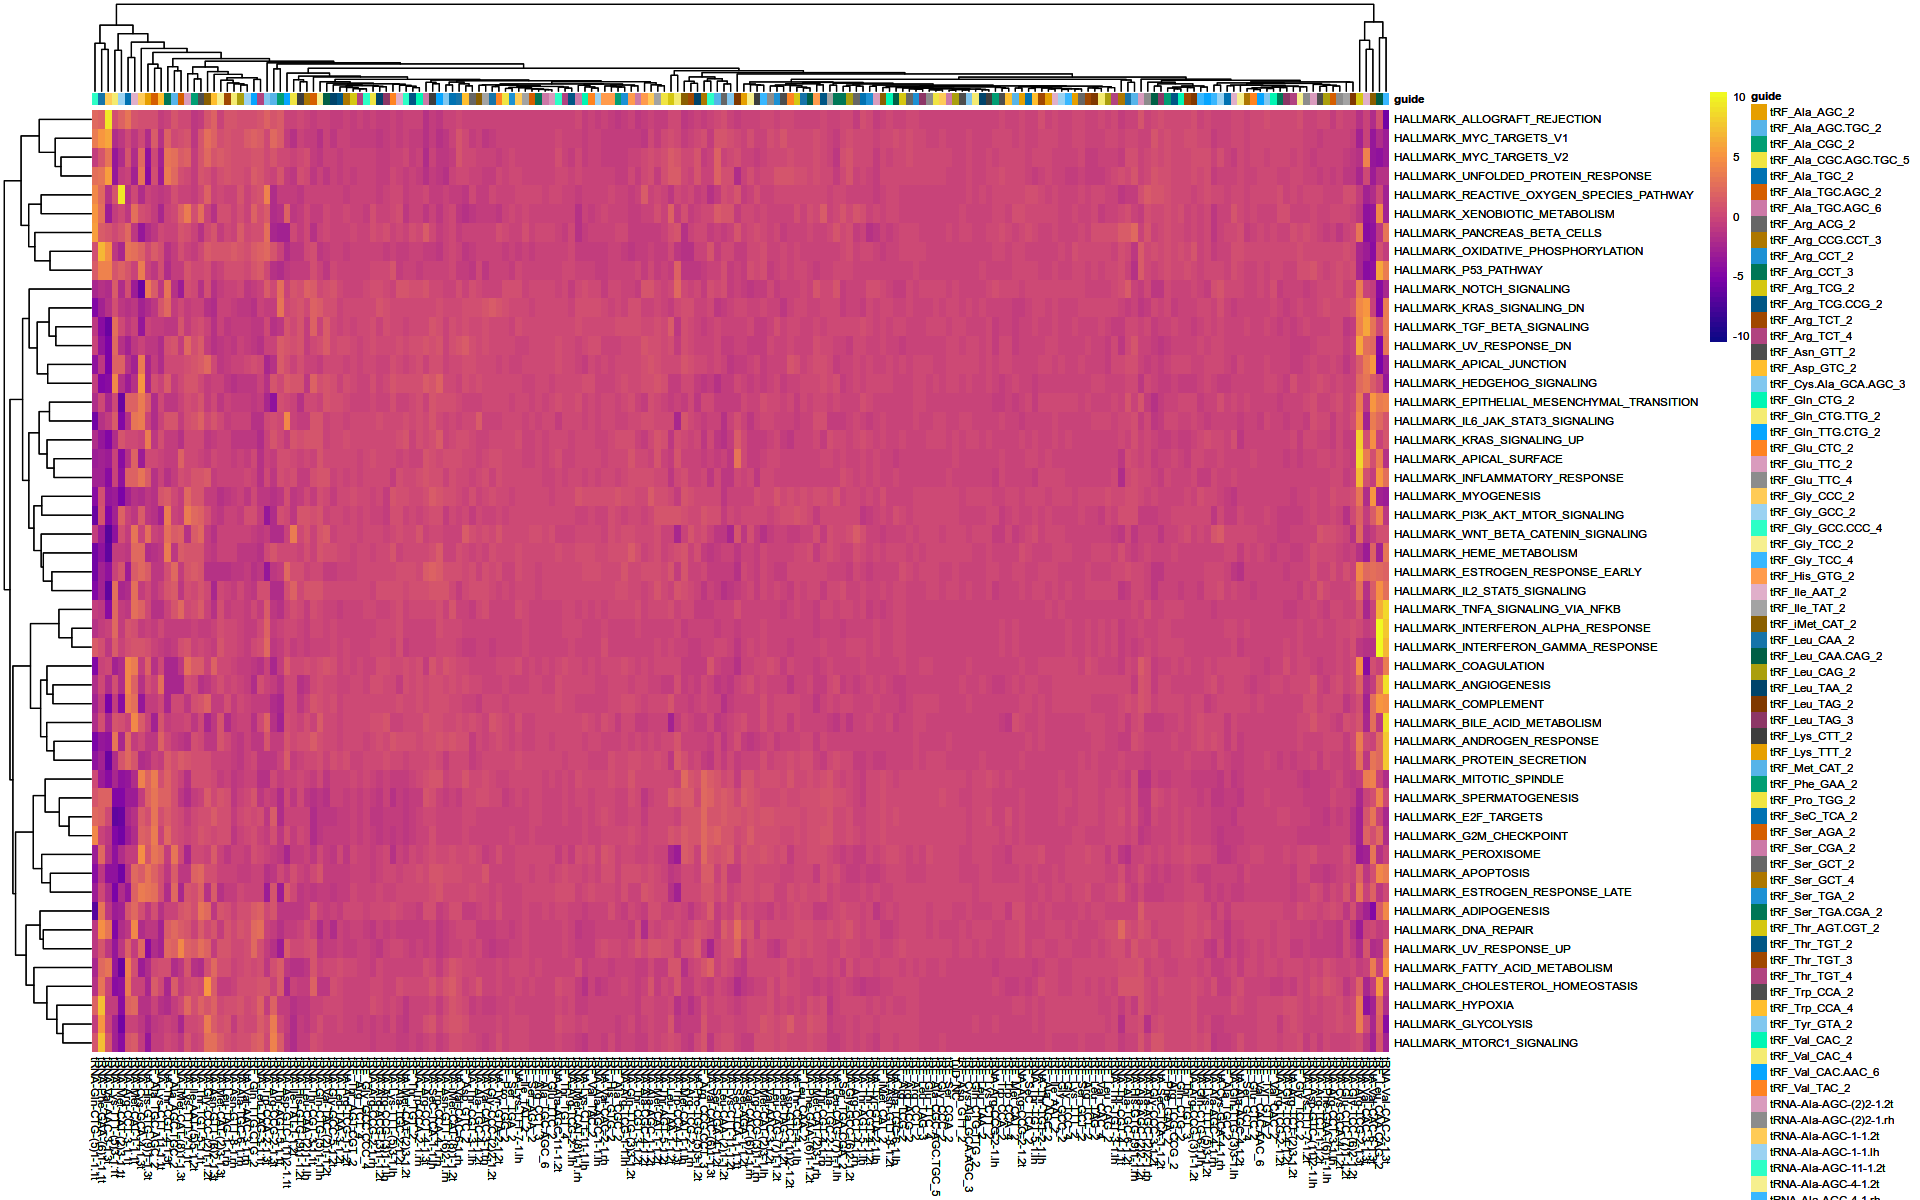

In [24]:
## better heatmap (using pheatmap and better color scheme)
coldat = cbind(guide = colnames(Pseudo_bulk_exp_counts), t(genesetexp_x_guide_FC))
coldat = as.data.frame(coldat)
rownames(coldat) = colnames(Pseudo_bulk_exp_counts)
coldat[, 2:ncol(coldat)] <- apply(coldat[, -1], 2, as.numeric)

bulkSE2 <- SummarizedExperiment(assays = list(counts = Pseudo_bulk_exp_counts,
             logcounts = Pseudo_bulk_exp), colData = coldat)

colors <- colorRampPalette(c("#0D0887FF","#7E03A8FF","#CC4678FF","#F89441FF","#F0F921FF"))
options(repr.plot.width = 16, repr.plot.height = 10)


htmp = dittoHeatmap(bulkSE2, genes = NULL, metas = as.character(rownames(genesetexp_x_guide_FC)), 
             annot.by = "guide", order.by = "guide", assay = 'logcounts',
             fontsize = 7, 
             cluster_cols = TRUE,
             heatmap.colors = colors(50))

htmp

In [25]:
### try averaging addmodule score across guides for each module and create heatmap

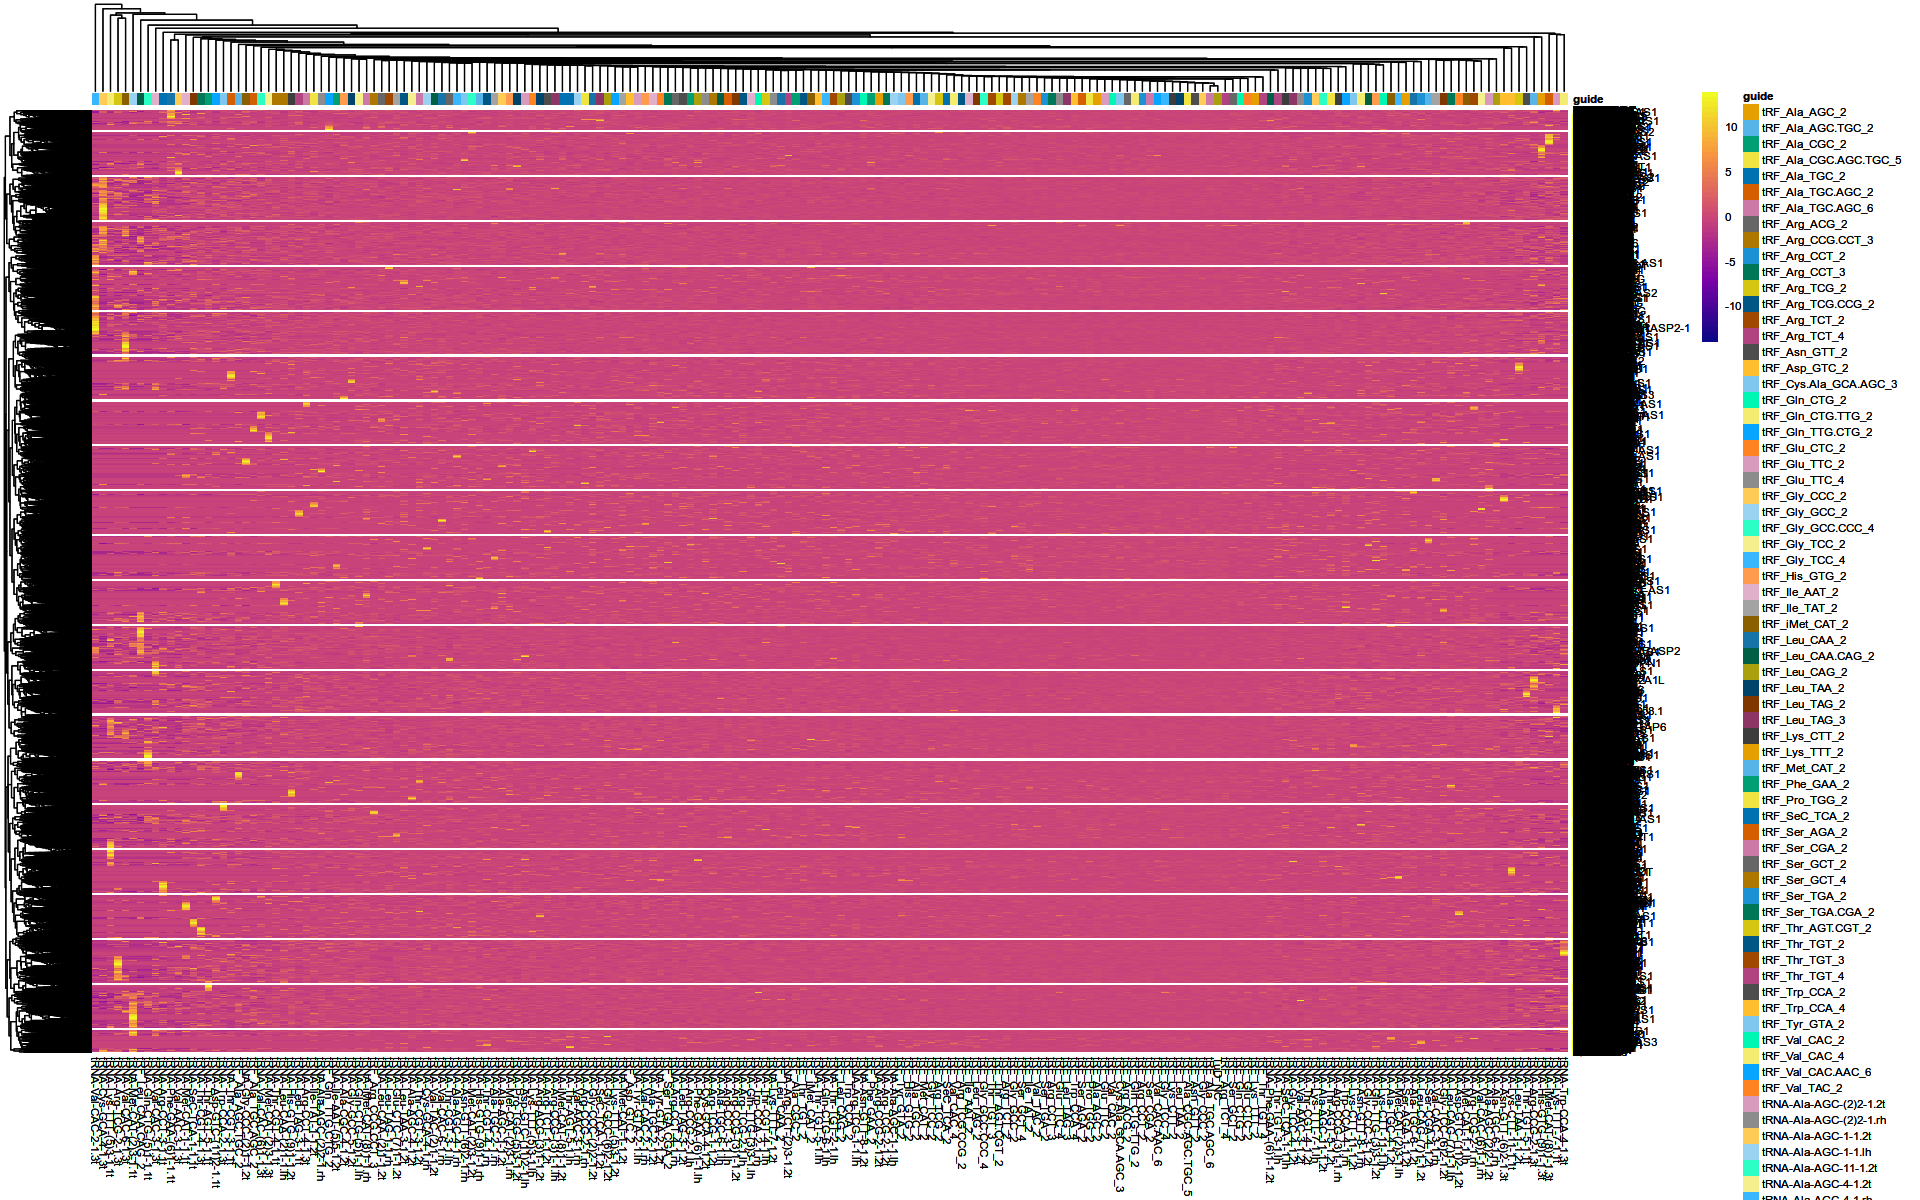

In [26]:
dittoHeatmap(bulkSE,
             annot.by = "guide", order.by = "guide", 
             fontsize = 7, 
             cluster_cols = TRUE,
             heatmap.colors = colors(50))

In [27]:
coldat

,guide,HALLMARK_ADIPOGENESIS,HALLMARK_ALLOGRAFT_REJECTION,HALLMARK_ANDROGEN_RESPONSE,HALLMARK_ANGIOGENESIS,HALLMARK_APICAL_JUNCTION,HALLMARK_APICAL_SURFACE,HALLMARK_APOPTOSIS,HALLMARK_BILE_ACID_METABOLISM,HALLMARK_CHOLESTEROL_HOMEOSTASIS,⋯,HALLMARK_PROTEIN_SECRETION,HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY,HALLMARK_SPERMATOGENESIS,HALLMARK_TGF_BETA_SIGNALING,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,HALLMARK_UV_RESPONSE_DN,HALLMARK_UV_RESPONSE_UP,HALLMARK_WNT_BETA_CATENIN_SIGNALING,HALLMARK_XENOBIOTIC_METABOLISM
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
tRF_Ala_AGC_2,tRF_Ala_AGC_2,1.0054654,1.0037112,1.0007229,0.9810173,1.0080402,1.0180629,0.9949679,0.9877023,1.0078481,⋯,0.9965536,0.9899283,0.9925170,0.9962823,1.0124675,1.0061165,1.0007322,0.9914437,1.0002039,1.0183916
tRF_Ala_AGC.TGC_2,tRF_Ala_AGC.TGC_2,0.9878022,1.0499577,0.9764439,0.6514657,1.0191565,0.9150797,1.0581483,0.9940859,1.0626026,⋯,1.0206898,1.1179156,1.0398158,0.9110258,1.0864654,1.0931004,1.0508814,1.0807975,1.1009208,1.0111116
tRF_Ala_CGC_2,tRF_Ala_CGC_2,0.9976959,0.9601636,0.9983004,1.0559711,0.9977927,1.0166518,0.9904029,0.9776569,1.0038786,⋯,1.0031856,0.9997080,0.9961559,1.0324106,1.0164295,0.9788698,0.9865636,1.0086250,1.0078764,1.0021877
tRF_Ala_CGC.AGC.TGC_5,tRF_Ala_CGC.AGC.TGC_5,1.0037672,0.9965221,0.9998570,0.9929639,0.9959589,0.9799094,1.0078968,1.0032872,0.9972776,⋯,1.0059893,0.9685625,1.0166699,1.0229787,1.0094658,1.0023848,0.9932837,1.0112235,0.9963158,1.0054794
tRF_Ala_TGC_2,tRF_Ala_TGC_2,0.9847373,1.0036190,0.9762002,1.0120307,0.9737527,0.9712361,0.9971197,0.9660078,0.9847083,⋯,0.9867404,1.0040867,0.9487930,0.9774466,0.9754455,0.9969548,0.9887765,0.9551097,0.9949599,0.9951328
tRF_Ala_TGC.AGC_2,tRF_Ala_TGC.AGC_2,1.0283189,1.0407455,0.9504030,1.0045494,0.9704093,1.0085799,1.0713253,0.8641740,1.0702482,⋯,0.9995612,0.9083137,1.2359206,0.9375385,0.8781775,1.0303978,0.9360487,0.9356140,0.9632507,0.9666435
tRF_Ala_TGC.AGC_6,tRF_Ala_TGC.AGC_6,1.0044922,1.0013971,1.0062885,1.0077739,0.9999511,0.9934226,1.0021702,1.0189029,1.0019922,⋯,1.0021901,0.9979713,0.9852710,1.0031192,1.0042757,0.9970400,0.9967639,0.9958631,1.0038408,1.0063815
tRF_Arg_ACG_2,tRF_Arg_ACG_2,1.0026619,1.0122864,0.9977225,0.9569228,0.9936688,0.9771994,0.9972294,0.9877865,1.0070056,⋯,0.9899895,0.9909599,1.0118636,0.9970925,0.9863754,1.0124061,0.9939034,1.0090218,0.9957227,1.0009187
tRF_Arg_CCG.CCT_3,tRF_Arg_CCG.CCT_3,1.0098896,0.9818127,0.9831864,1.0594730,1.0170754,0.9169193,1.0551124,0.9680387,1.0029227,⋯,0.9668069,0.9848072,1.1780111,0.9584545,0.9718070,0.9948970,0.9779668,0.9863932,1.0299174,1.0113139
